# Методы оптимизации

# Обучение с обычным SGD

Загрузим данные, создадим модель и обучим с обычным SGD.

USE CUDA: True


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw

Train size: 10000
Test size: 10000


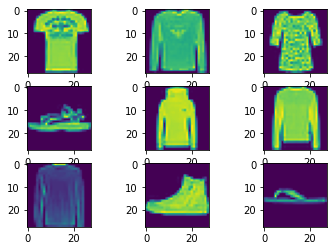

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from tqdm import tqdm

USE_CUDA = torch.cuda.is_available()
print("USE CUDA:", USE_CUDA)

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 10000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = FashionMNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = FashionMNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0).squeeze(-1))
    plt.show()

draw(train)

In [2]:
def compute_accuracy(model, loader):
    if USE_CUDA:
        model.cuda()
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in loader:
        if USE_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

Num parameters 3226
Epoch 0, loss 2.191, train 0.534, test 0.536
Epoch 1, loss 1.213, train 0.690, test 0.687
Epoch 2, loss 0.844, train 0.712, test 0.708
Epoch 3, loss 0.777, train 0.723, test 0.715
Epoch 4, loss 0.752, train 0.730, test 0.723
Epoch 5, loss 0.741, train 0.734, test 0.725
Epoch 6, loss 0.735, train 0.735, test 0.728
Epoch 7, loss 0.733, train 0.736, test 0.728
Epoch 8, loss 0.731, train 0.735, test 0.729
Epoch 9, loss 0.731, train 0.736, test 0.729
Weights norm 3.8519320487976074


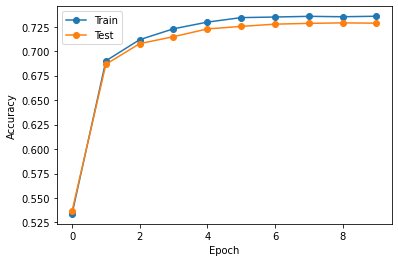

In [3]:
def get_model():
    torch.manual_seed(0)
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 4, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(4, 8, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(288, 10)
    )

def run(model, optimizer, epochs=10, scheduler=None):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    if USE_CUDA:
        model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for images, labels in loader:
            if USE_CUDA:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        train_accuracy = compute_accuracy(model, loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(np.mean(losses))
            else:
                scheduler.step()
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
run(model, optimizer)

При обучении с обычным SGD модель достигла точности 72.9% на тестовом корпусе. Попробуем улучшить.

# Улучшения

**Задание 1**. Примените `torch.optim.RMSprop`. Получите точность на test не меньше 82%.

In [16]:
model = get_model()
optimizer = torch.optim.RMSprop(model.parameters(), momentum=0.9)  # Ваш код.
        
run(model, optimizer)

Num parameters 3226
Epoch 0, loss 2.324, train 0.100, test 0.100
Epoch 1, loss 2.310, train 0.100, test 0.100
Epoch 2, loss 2.307, train 0.100, test 0.100


KeyboardInterrupt: ignored

**Задание 2.** Примените `torch.optim.Adam`. Получите точность на test не менее 83%.

Num parameters 3226
Epoch 0, loss 0.700, train 0.827, test 0.813
Epoch 1, loss 0.466, train 0.843, test 0.824
Epoch 2, loss 0.421, train 0.845, test 0.823
Epoch 3, loss 0.397, train 0.859, test 0.836
Epoch 4, loss 0.385, train 0.864, test 0.839
Epoch 5, loss 0.378, train 0.866, test 0.840
Epoch 6, loss 0.374, train 0.868, test 0.840
Epoch 7, loss 0.372, train 0.868, test 0.840
Epoch 8, loss 0.371, train 0.867, test 0.840
Epoch 9, loss 0.370, train 0.867, test 0.841
Weights norm 11.94719409942627


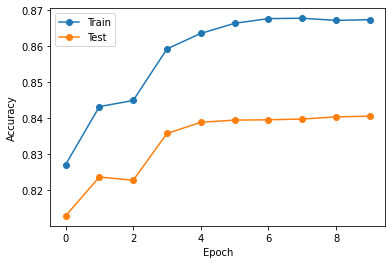

In [12]:
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-4) # Ваш код.

run(model, optimizer)

**Задание 3**. Примените momentum SGD. Получите точность на test не меньше 82%.

Num parameters 3226
Epoch 0, loss 1.003, train 0.786, test 0.776
Epoch 1, loss 0.537, train 0.817, test 0.804
Epoch 2, loss 0.484, train 0.835, test 0.813
Epoch 3, loss 0.461, train 0.833, test 0.811
Epoch 4, loss 0.449, train 0.839, test 0.821
Epoch 5, loss 0.443, train 0.846, test 0.823
Epoch 6, loss 0.439, train 0.844, test 0.823
Epoch 7, loss 0.437, train 0.844, test 0.823
Epoch 8, loss 0.436, train 0.844, test 0.824
Epoch 9, loss 0.436, train 0.844, test 0.824
Weights norm 6.084926605224609


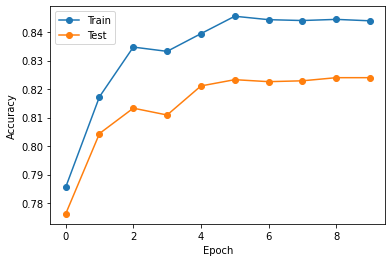

In [17]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Ваш код.
        
run(model, optimizer)

**Задание 4.** Примените Nesterov momentum. Получилось ли увеличить точность на train/test?

Num parameters 3226
Epoch 0, loss 0.965, train 0.795, test 0.783
Epoch 1, loss 0.523, train 0.817, test 0.803
Epoch 2, loss 0.476, train 0.838, test 0.819
Epoch 3, loss 0.453, train 0.839, test 0.819
Epoch 4, loss 0.442, train 0.842, test 0.822
Epoch 5, loss 0.435, train 0.848, test 0.827
Epoch 6, loss 0.432, train 0.848, test 0.826
Epoch 7, loss 0.430, train 0.848, test 0.827
Epoch 8, loss 0.429, train 0.848, test 0.827
Epoch 9, loss 0.428, train 0.848, test 0.827
Weights norm 6.029731750488281


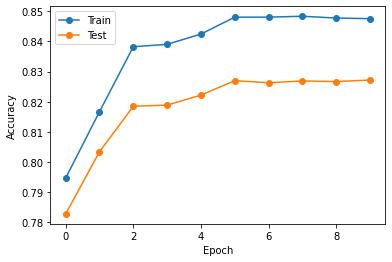

In [18]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)  # Ваш код.
        
run(model, optimizer)

**Задание 5** Попробуйте добиться точности 83.5% на test используя momentum SGD и `torch.optim.lr_scheduler.StepLR` для изменения learning rate в процессе обучения.

Num parameters 3226
Epoch 0, loss 1.003, train 0.786, test 0.776
Epoch 1, loss 0.563, train 0.809, test 0.796
Epoch 2, loss 0.510, train 0.823, test 0.809
Epoch 3, loss 0.479, train 0.836, test 0.820
Epoch 4, loss 0.457, train 0.843, test 0.820
Epoch 5, loss 0.440, train 0.853, test 0.828
Epoch 6, loss 0.425, train 0.858, test 0.830
Epoch 7, loss 0.413, train 0.862, test 0.831
Epoch 8, loss 0.403, train 0.864, test 0.835
Epoch 9, loss 0.392, train 0.867, test 0.837
Weights norm 9.675904273986816


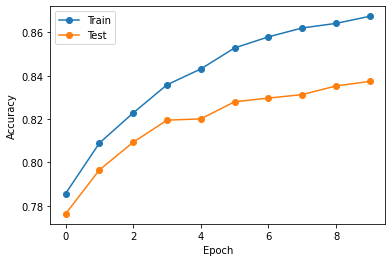

In [19]:
model = get_model()
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Ваш код.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
run(model, optimizer, scheduler=scheduler)

**Выводы:**
1. Какой optimizer показал себя лучше?
2. Какие параметры сильнее всего влияли на обучение?
3. Помог ли scheduler? Насколько?